In [1]:
import os
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from scipy.ndimage import uniform_filter1d
from scipy.io import loadmat
import re
from sklearn.metrics import roc_curve, roc_auc_score

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
val_l=[]

train_l=[]

train_path="/kaggle/input/anomaly1/UCSDped2/Train"
train_images=[]
for root,dirnames, files in os.walk(train_path):
    dirnames[:] = [d for d in dirnames if not d.endswith("gt")]
    dirnames.sort()
    files = [file for file in files if not file.lower().endswith(('.m', '~'))]
    files.sort()
    train_l.append((root, len(files)))
    for file in files:
        image_path=os.path.join(root,file)
        image=cv.imread(image_path,cv.IMREAD_UNCHANGED)
        image = cv.resize(image, (235, 155))
        train_images.append(image)

train_images=np.array(train_images)

val_path="/kaggle/input/anomaly1/UCSDped2/Test"
val_images=[]
for root,dirnames, files in os.walk(val_path):
    dirnames[:] = [d for d in dirnames if not d.endswith("gt")]
    dirnames.sort()
    valid_files = [file for file in files if not file.lower().endswith(('.m', '~'))]
    valid_files.sort()
    val_l.append((root, len(valid_files)))
    for file in valid_files:
        image_path=os.path.join(root,file)
        image=cv.imread(image_path,cv.IMREAD_UNCHANGED)
        image = cv.resize(image, (235, 155))
        val_images.append(image)

val_images=np.array(val_images)
print(train_l)
print(val_l)
print(train_images.shape)
print(val_images.shape)
        

cuda
[('/kaggle/input/anomaly1/UCSDped2/Train', 0), ('/kaggle/input/anomaly1/UCSDped2/Train/Train001', 120), ('/kaggle/input/anomaly1/UCSDped2/Train/Train002', 150), ('/kaggle/input/anomaly1/UCSDped2/Train/Train003', 150), ('/kaggle/input/anomaly1/UCSDped2/Train/Train004', 180), ('/kaggle/input/anomaly1/UCSDped2/Train/Train005', 180), ('/kaggle/input/anomaly1/UCSDped2/Train/Train006', 150), ('/kaggle/input/anomaly1/UCSDped2/Train/Train007', 150), ('/kaggle/input/anomaly1/UCSDped2/Train/Train008', 120), ('/kaggle/input/anomaly1/UCSDped2/Train/Train009', 180), ('/kaggle/input/anomaly1/UCSDped2/Train/Train010', 180), ('/kaggle/input/anomaly1/UCSDped2/Train/Train011', 180), ('/kaggle/input/anomaly1/UCSDped2/Train/Train012', 180), ('/kaggle/input/anomaly1/UCSDped2/Train/Train013', 180), ('/kaggle/input/anomaly1/UCSDped2/Train/Train014', 150), ('/kaggle/input/anomaly1/UCSDped2/Train/Train015', 150), ('/kaggle/input/anomaly1/UCSDped2/Train/Train016', 150)]
[('/kaggle/input/anomaly1/UCSDped2/T

In [3]:
new_val_l=[]
for i in range(len(val_l)):
    if val_l[i][1]!=0:
        new_val_l.append((val_l[i][0].split("/")[-1][-3:],val_l[i][1]))
new_val_l.sort()

new_train_l=[]
for i in range(len(train_l)):
    if train_l[i][1]!=0:
        new_train_l.append((train_l[i][0].split("/")[-1][-3:],train_l[i][1]))
new_train_l.sort()

print(new_train_l)
gt_file_path = "/kaggle/input/anomaly1/UCSDped2/Test/UCSDped2.m"  
with open(gt_file_path, 'r') as file:
    lines = file.readlines()
#print(lines)
gt=[]
for i in range(1,len(lines)):
    line=lines[i].split(" ")[-1]
    nrs = re.split(r'[ \[\]:]+', line)
    start, finish=int(nrs[1]),int(nrs[2])
    gt.append([0]*new_val_l[i-1][1])
    #print(len([0]*new_val_l[i-1][1]))
    gt[i-1][start-1:finish]=[1] * (finish - start + 1)

print(new_val_l)

[('001', 120), ('002', 150), ('003', 150), ('004', 180), ('005', 180), ('006', 150), ('007', 150), ('008', 120), ('009', 180), ('010', 180), ('011', 180), ('012', 180), ('013', 180), ('014', 150), ('015', 150), ('016', 150)]
[('001', 180), ('002', 180), ('003', 150), ('004', 180), ('005', 150), ('006', 180), ('007', 180), ('008', 180), ('009', 120), ('010', 150), ('011', 180), ('012', 180)]


In [4]:
print(train_images[0].shape)

(155, 235)


In [4]:
class CAE(nn.Module):
    def __init__(self,chanels):
        super(CAE, self).__init__()
        
        
        self.conv1 = nn.Conv2d(in_channels=chanels, out_channels=256, kernel_size=11, stride=4)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(in_channels=256, out_channels=128, kernel_size=1, stride=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=1, stride=1)

        
        self.deconv1 = nn.ConvTranspose2d(in_channels=64, out_channels=128, kernel_size=1, stride=1)
        self.upsample1 = nn.Upsample(scale_factor=2, mode='nearest')
        self.deconv2 = nn.ConvTranspose2d(in_channels=128, out_channels=256, kernel_size=1, stride=1)
        self.upsample2 = nn.Upsample(scale_factor=2, mode='nearest')
        self.deconv3 = nn.ConvTranspose2d(in_channels=256, out_channels=chanels, kernel_size=15, stride=4)

    def forward(self, x):
 
        x = self.conv1(x)
        #print(f"After Conv1: {x.shape}")
        x = torch.tanh(x)
        x = self.pool1(x)
        #print(f"After Pool1: {x.shape}")

        x = self.conv2(x)
        #print(f"After Conv2: {x.shape}")
        x = torch.tanh(x)
        x = self.pool2(x)
        #print(f"After Pool2: {x.shape}")

        x = self.conv3(x)
        #print(f"After Conv3: {x.shape}")
        x = torch.tanh(x)


        x = self.deconv1(x)
        #print(f"After Deconv1: {x.shape}")
        x = torch.tanh(x)
        x = self.upsample1(x)
        #print(f"After Upsample1: {x.shape}")

        x = self.deconv2(x)
        #print(f"After Deconv2: {x.shape}")
        x = torch.tanh(x)
        x = self.upsample2(x)
        #print(f"After Upsample2: {x.shape}")

        x = self.deconv3(x)
        #print(f"After Deconv3: {x.shape}")
        x = torch.tanh(x)

        return x

class CustomData(Dataset):
    def __init__(self,images,canny=0,optical_flow=0,optical_images=[]):
        self.images=images
        self.canny=canny
        self.optical_flow=optical_flow
        self.optical_images=optical_images

    def __len__(self):
        return len(self.images)


    def __getitem__(self, idx):

        image_tensor = torch.tensor(self.images[idx], dtype=torch.float32)
        image_tensor = image_tensor / 255.0 
        image_tensor = 2 * image_tensor - 1 
            
        if self.canny==1 and self.optical_flow==0:
            edges = cv.Canny(self.images[idx], threshold1=100, threshold2=200)
            edges_tensor = torch.tensor(edges, dtype=torch.float32) / 255.0
            edges_tensor = 2 * edges_tensor - 1
            return image_tensor,edges_tensor, image_tensor,edges_tensor

        if self.canny==0 and self.optical_flow==1:
            optical_image=self.optical_images[idx]
            optical_tensor = torch.tensor(optical_image, dtype=torch.float32)
            image_tensor = torch.tensor(self.images[idx], dtype=torch.float32)
            image_tensor = image_tensor / 255.0  
            image_tensor = 2 * image_tensor - 1 
            return image_tensor,optical_tensor, image_tensor,optical_tensor


        if self.canny==1 and self.optical_flow==1:
            edges = cv.Canny(self.images[idx], threshold1=100, threshold2=200)
            edges_tensor = torch.tensor(edges, dtype=torch.float32) / 255.0
            edges_tensor = 2 * edges_tensor - 1

            optical_image=self.optical_images[idx]
            optical_tensor = torch.tensor(optical_image, dtype=torch.float32)
            image_tensor = torch.tensor(self.images[idx], dtype=torch.float32)
            image_tensor = image_tensor / 255.0  
            image_tensor = 2 * image_tensor - 1  

            return image_tensor,edges_tensor,optical_tensor, image_tensor, edges_tensor, optical_tensor
        return image_tensor,image_tensor
            
                
            
            
            
            

def compute_per_pixel_reconstruction_error(input_frame, reconstructed_frame):
    pixel_differences = input_frame - reconstructed_frame
    pixel_errors = np.sqrt(pixel_differences**2)
    return pixel_errors

def compute_frame_reconstruction_error(pixel_errors):
    return np.sum(pixel_errors)

def smooth_fre(fre_values, window_size):
    smooth=[]
    for i in range(len(fre_values)-window_size):
        smooth.append(sum(fre_values[i:i+window_size])/window_size)
    for i in range(len(fre_values)-window_size,len(fre_values)):
        smooth.append(sum(fre_values[i:])/(len(fre_values)-i))
    return smooth

def compute_rre(smoothed_fre,min_val,max_val):
    smoothed_fre=np.array(smoothed_fre)
    return (smoothed_fre - min_val) / (max_val - min_val)

def compute_optical_flow(frame1, frame2):


    flow = cv.calcOpticalFlowFarneback(frame1, frame2, None, 
                                        pyr_scale=0.5, levels=3, winsize=15, 
                                        iterations=3, poly_n=5, poly_sigma=1.2, 
                                        flags=0)

    flow_x = flow[..., 0]
    flow_y = flow[..., 1]

    magnitude = np.sqrt(flow_x ** 2 + flow_y ** 2)

    grayscale_optical_flow = cv.normalize(magnitude, None, -1, 1, cv.NORM_MINMAX)


    return grayscale_optical_flow


In [6]:
train_optical=[]
val_optical=[]
train_images_optical=np.array([])
val_images_optical=np.array([])
aux=0
for file in new_train_l:
    for i in range(aux,aux+file[1]-1):
        train_optical.append(compute_optical_flow(train_images[i],train_images[i+1]))
    if train_images_optical.size == 0: 
        train_images_optical = train_images[aux+1:aux+file[1]]
    else:
        train_images_optical = np.concatenate((train_images_optical, train_images[aux+1:aux+file[1]]), axis=0)

    aux+=file[1]

aux=0
for file in new_val_l:
    for i in range(aux,aux+file[1]-1):
        val_optical.append(compute_optical_flow(val_images[i],val_images[i+1]))
    if val_images_optical.size == 0: 
        val_images_optical = train_images[aux+1:aux+file[1]]
    else:
        val_images_optical = np.concatenate((val_images_optical, val_images[aux+1:aux+file[1]]), axis=0)
    aux+=file[1]


In [9]:
print(len(train_images))

2550


In [8]:

train_dataset = CustomData(train_images_optical,optical_flow=1,canny=1,optical_images=train_optical)
val_dataset = CustomData(val_images_optical,optical_flow=1,canny=1,optical_images=val_optical)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=120, shuffle=False)

def initialize_weights_xavier(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

model = CAE(chanels=3).to(device)
model.apply(initialize_weights_xavier)

criterion = nn.MSELoss()
optimizer = torch.optim.Adagrad(model.parameters(), lr=0.001)

best_val_metric = float('inf')  
best_model_path = "best_model.pth"  

epochs = 100
min1 = 1e7
max1 = -1e7

for epoch in range(epochs):
    model.train()
    epoch_loss = 0.0
    total_smooth = []
    test = []

    for input_fr, input_edge, input_optic, target_fr, target_edge, target_optic in train_loader:
        input_fr, target_fr = input_fr.to(device), target_fr.to(device)
        input_edge, target_edge=input_edge.to(device), target_edge.to(device)
        input_optic, target_optic=input_optic.to(device), target_optic.to(device)
                
        input_fr = input_fr.unsqueeze(1)
        input_edge = input_edge.unsqueeze(1)
        input_optic=input_optic.unsqueeze(1)
        
        target_fr = target_fr.unsqueeze(1)
        target_edge = target_edge.unsqueeze(1)
        target_optic=target_optic.unsqueeze(1)

        inputs = torch.cat((input_fr, input_edge,input_optic), dim=1)  
        targets = torch.cat((target_fr, target_edge, target_optic), dim=1) 

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        inputs = inputs.detach().cpu().numpy()
        outputs = outputs.detach().cpu().numpy()

        all_pixel_errors = [
            compute_per_pixel_reconstruction_error(inputs[i], outputs[i])
            for i in range(len(inputs))
        ]

        fre_values = [compute_frame_reconstruction_error(pixel_errors) for pixel_errors in all_pixel_errors]
        test.extend(fre_values)

        smoothed_fre = smooth_fre(np.array(fre_values), window_size=3)
        total_smooth.extend(smoothed_fre)

    min1 = min(total_smooth)
    max1 = max(total_smooth)
    print(min1, max1)
    print(np.mean(test))
    avg_loss = epoch_loss / len(train_loader)


    model.eval()
    epoch_loss_val = 0
    total_smooth_val = []
    test_val = []
    hmm = []

    with torch.no_grad():
        for input_fr,input_edge, input_optic, target_fr, target_edge, target_optic  in val_loader:
            input_fr, target_fr = input_fr.to(device), target_fr.to(device)
            input_edge, target_edge=input_edge.to(device), target_edge.to(device)
            input_optic, target_optic=input_optic.to(device), target_optic.to(device)
                    
            input_fr = input_fr.unsqueeze(1)
            input_edge = input_edge.unsqueeze(1)
            input_optic=input_optic.unsqueeze(1)
            
            target_fr = target_fr.unsqueeze(1)
            target_edge = target_edge.unsqueeze(1)
            target_optic=target_optic.unsqueeze(1)

            
            inputs = torch.cat((input_fr, input_edge,input_optic), dim=1)  
            targets = torch.cat((target_fr, target_edge, target_optic), dim=1) 

            outputs = model(inputs)
            loss = criterion(outputs, targets)
            epoch_loss_val += loss.item()

            inputs = inputs.detach().cpu().numpy()
            outputs = outputs.detach().cpu().numpy()

            all_pixel_errors = [
                compute_per_pixel_reconstruction_error(inputs[i], outputs[i])
                for i in range(len(inputs))
            ]

            fre_values = [compute_frame_reconstruction_error(pixel_errors) for pixel_errors in all_pixel_errors]
            test_val.extend(fre_values)

            smoothed_fre = smooth_fre(np.array(fre_values), window_size=1)
            hmm.extend(smoothed_fre)
            total_smooth_val.extend(smoothed_fre)

    val_metric = np.mean(test_val) 
    print(val_metric, "val")
    print(np.mean(hmm), "smooth")

    avg_loss_val = epoch_loss_val / len(val_loader)

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}, Loss_val: {avg_loss_val:.4f}")

    if val_metric < best_val_metric:
        best_val_metric = val_metric
        torch.save(model.state_dict(), best_model_path)
        print(f"Best model saved at epoch {epoch+1} with val_metric: {best_val_metric:.4f}")

print("Training complete!")
print(f"Best model saved with val_metric: {best_val_metric:.4f} at {best_model_path}")

6991.310221354167 12858.017578125
9072.73
10786.867 val
10786.867370544373 smooth
Epoch [87/100], Loss: 0.0424, Loss_val: 0.0559
Best model saved at epoch 87 with val_metric: 10786.8672
6981.164876302083 12846.3701171875
9061.2705
10775.699 val
10775.699901317334 smooth
Epoch [88/100], Loss: 0.0423, Loss_val: 0.0558
Best model saved at epoch 88 with val_metric: 10775.6992
6971.131184895833 12835.015625
9049.982
10764.773 val
10764.773598305337 smooth
Epoch [89/100], Loss: 0.0423, Loss_val: 0.0557
Best model saved at epoch 89 with val_metric: 10764.7734
6961.609375 12823.017578125
9038.883
10753.959 val
10753.958548636527 smooth
Epoch [90/100], Loss: 0.0422, Loss_val: 0.0557
Best model saved at epoch 90 with val_metric: 10753.9590
6952.152994791667 12811.623046875
9028.007
10743.317 val
10743.318051694272 smooth
Epoch [91/100], Loss: 0.0421, Loss_val: 0.0556
Best model saved at epoch 91 with val_metric: 10743.3174
6942.986490885417 12799.7001953125
9017.314
10732.846 val
10732.845350721

In [119]:
model.load_state_dict(torch.load("best_model.pth"))

<ipython-input-119-4e55fec23aa2>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))


<All keys matched successfully>

In [121]:
print(best_val_metric)

2487.4119


In [19]:
best_val_metric = float('inf')  
best_model_path = "best_model.pth" 

epochs = 800
min1 = 1e7
max1 = -1e7

for epoch in range(epochs):
    model.train()
    epoch_loss = 0.0
    total_smooth = []
    test = []

    for input_fr, input_edge, input_optic, target_fr, target_edge, target_optic in train_loader:
        input_fr, target_fr = input_fr.to(device), target_fr.to(device)
        input_edge, target_edge=input_edge.to(device), target_edge.to(device)
        input_optic, target_optic=input_optic.to(device), target_optic.to(device)
                
        input_fr = input_fr.unsqueeze(1)
        input_edge = input_edge.unsqueeze(1)
        input_optic=input_optic.unsqueeze(1)
        
        target_fr = target_fr.unsqueeze(1)
        target_edge = target_edge.unsqueeze(1)
        target_optic=target_optic.unsqueeze(1)

        inputs = torch.cat((input_fr, input_edge,input_optic), dim=1)  
        targets = torch.cat((target_fr, target_edge, target_optic), dim=1) 

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        inputs = inputs.detach().cpu().numpy()
        outputs = outputs.detach().cpu().numpy()

        all_pixel_errors = [
            compute_per_pixel_reconstruction_error(inputs[i], outputs[i])
            for i in range(len(inputs))
        ]

        fre_values = [compute_frame_reconstruction_error(pixel_errors) for pixel_errors in all_pixel_errors]
        test.extend(fre_values)

        smoothed_fre = smooth_fre(np.array(fre_values), window_size=3)
        total_smooth.extend(smoothed_fre)

    min1 = min(total_smooth)
    max1 = max(total_smooth)
    print(min1, max1)
    print(np.mean(test))
    avg_loss = epoch_loss / len(train_loader)


    model.eval()
    epoch_loss_val = 0
    total_smooth_val = []
    test_val = []
    hmm = []

    with torch.no_grad():
        for input_fr,input_edge, input_optic, target_fr, target_edge, target_optic  in val_loader:
            input_fr, target_fr = input_fr.to(device), target_fr.to(device)
            input_edge, target_edge=input_edge.to(device), target_edge.to(device)
            input_optic, target_optic=input_optic.to(device), target_optic.to(device)
                    
            input_fr = input_fr.unsqueeze(1)
            input_edge = input_edge.unsqueeze(1)
            input_optic=input_optic.unsqueeze(1)
            
            target_fr = target_fr.unsqueeze(1)
            target_edge = target_edge.unsqueeze(1)
            target_optic=target_optic.unsqueeze(1)

            
            inputs = torch.cat((input_fr, input_edge,input_optic), dim=1)  
            targets = torch.cat((target_fr, target_edge, target_optic), dim=1) 

            outputs = model(inputs)
            loss = criterion(outputs, targets)
            epoch_loss_val += loss.item()

            inputs = inputs.detach().cpu().numpy()
            outputs = outputs.detach().cpu().numpy()

            all_pixel_errors = [
                compute_per_pixel_reconstruction_error(inputs[i], outputs[i])
                for i in range(len(inputs))
            ]

            fre_values = [compute_frame_reconstruction_error(pixel_errors) for pixel_errors in all_pixel_errors]
            test_val.extend(fre_values)

            smoothed_fre = smooth_fre(np.array(fre_values), window_size=1)
            hmm.extend(smoothed_fre)
            total_smooth_val.extend(smoothed_fre)

    val_metric = np.mean(test_val)  
    print(val_metric, "val")
    print(np.mean(hmm), "smooth")

    avg_loss_val = epoch_loss_val / len(val_loader)

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}, Loss_val: {avg_loss_val:.4f}")


    if val_metric < best_val_metric:
        best_val_metric = val_metric
        torch.save(model.state_dict(), best_model_path)
        print(f"Best model saved at epoch {epoch+1} with val_metric: {best_val_metric:.4f}")

print("Training complete!")
print(f"Best model saved with val_metric: {best_val_metric:.4f} at {best_model_path}")
#260

6103.841145833333 11844.658203125
8059.4824
9767.175 val
9767.175473569272 smooth
Epoch [1/800], Loss: 0.0361, Loss_val: 0.0498
Best model saved at epoch 1 with val_metric: 9767.1748
6098.589680989583 11839.7353515625
8055.999
9763.838 val
9763.838443668277 smooth
Epoch [2/800], Loss: 0.0361, Loss_val: 0.0497
Best model saved at epoch 2 with val_metric: 9763.8379
6094.838053385417 11836.73828125
8052.465
9760.504 val
9760.503632294403 smooth
Epoch [3/800], Loss: 0.0361, Loss_val: 0.0497
Best model saved at epoch 3 with val_metric: 9760.5039
6091.374186197917 11833.7685546875
8049.0938
9757.213 val
9757.21303114638 smooth
Epoch [4/800], Loss: 0.0361, Loss_val: 0.0497
Best model saved at epoch 4 with val_metric: 9757.2129
6088.033528645833 11830.78515625
8045.8076
9753.953 val
9753.953074656689 smooth
Epoch [5/800], Loss: 0.0361, Loss_val: 0.0497
Best model saved at epoch 5 with val_metric: 9753.9531
6084.78564453125 11827.8818359375
8042.5747
9750.707 val
9750.707292253192 smooth
Epoch 

KeyboardInterrupt: 

In [22]:
val_loader=DataLoader(val_dataset, batch_size=120, shuffle=False)
model.eval()
out=[]
total_smooth_val=[]
yup=[]
with torch.no_grad():
    for input_fr,input_edge, input_optic, target_fr, target_edge, target_optic  in val_loader:
        input_fr, target_fr = input_fr.to(device), target_fr.to(device)
        input_edge, target_edge=input_edge.to(device), target_edge.to(device)
        input_optic, target_optic=input_optic.to(device), target_optic.to(device)
                
        input_fr = input_fr.unsqueeze(1)
        input_edge = input_edge.unsqueeze(1)
        input_optic=input_optic.unsqueeze(1)
        
        target_fr = target_fr.unsqueeze(1)
        target_edge = target_edge.unsqueeze(1)
        target_optic=target_optic.unsqueeze(1)

        
        inputs = torch.cat((input_fr, input_edge,input_optic), dim=1)  
        targets = torch.cat((target_fr, target_edge, target_optic), dim=1) 

        outputs=model(inputs)
        
        inputs = inputs.detach().cpu().numpy()
        outputs = outputs.detach().cpu().numpy()
        all_pixel_errors = [
            compute_per_pixel_reconstruction_error(inputs[i], outputs[i])
            for i in range(len(inputs))
        ]
    
        fre_values = [compute_frame_reconstruction_error(pixel_errors) for pixel_errors in all_pixel_errors]
        yup.extend(fre_values)
        
        smoothed_fre = smooth_fre(np.array(fre_values), window_size=5)

        total_smooth_val.extend(smoothed_fre)
total_smooth_val=np.array(total_smooth_val)

print(min1,max1)
rre_values_val = compute_rre(total_smooth_val,min1,max1)
print(total_smooth_val[0:180])
flattened_gt = []
for l in gt:
    for nr in l:
        flattened_gt.append(nr)


indices = [idx[1] for idx in new_val_l]

cumulative_indices = [0] 
for val in indices:
    cumulative_indices.append(cumulative_indices[-1] + val)

cumulative_indices = [i for i in cumulative_indices if i < len(flattened_gt)]


for index in sorted(cumulative_indices, reverse=True):  
    del flattened_gt[index]
print(len(flattened_gt))


auc = roc_auc_score(flattened_gt, rre_values_val)
print(auc)
fpr, tpr, thresholds = roc_curve(flattened_gt, rre_values_val)
fnr = 1 - tpr 
eer_threshold_index = np.nanargmin(np.abs(fnr - fpr))  
eer = fpr[eer_threshold_index]
eer_threshold = thresholds[eer_threshold_index]
print(f"EER: {eer:.4f} at Threshold: {eer_threshold:.4f}")


5947.313313802083 11701.951171875
[10800.06992187 10508.93496094 10294.28164063 10263.55644531
 10141.70898438 10267.47460938 10275.32792969 10492.31464844
 10476.32675781 10558.38828125 10451.05703125 10452.93183594
 10274.78671875 10319.13378906 10340.40234375 10324.48398437
 10442.51816406 10500.353125   10395.18203125 10301.89746094
 10357.39960937 10325.74199219 10382.07441406 10421.26074219
 10459.46601562 10503.94472656 10442.4609375  10283.76953125
 10409.24179687 10519.24765625 10482.63300781 10583.53476562
 10682.80820312 10555.11699219 10440.63085938 10327.06875
 10081.16132812  9953.83300781  9868.47753906  9852.64726563
  9878.31015625  9914.89042969  9839.51699219  9931.88261719
  9859.090625    9790.08417969  9796.20332031  9867.02128906
  9810.83320312  9818.39101563  9842.18222656  9754.46933594
  9704.35332031  9700.91660156  9699.72148438  9810.20996094
  9912.71074219  9914.60703125  9903.97597656 10029.09003906
  9989.04316406  9920.32519531  9978.27910156  9952.04

In [ ]:
model.eval()

image_path = "/kaggle/input/anomaly1/UCSDped2/Test/Test001/136.tif"
image = cv.imread(image_path, cv.IMREAD_UNCHANGED)

if len(image.shape) == 3:
    image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)

image = cv.resize(image, (235, 155))

image = image.astype(np.float32)
image = image / 255.0
image = 2 * image - 1

image_tensor = torch.tensor(image, dtype=torch.float32)

image_tensor = image_tensor.unsqueeze(0).unsqueeze(0)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
image_tensor = image_tensor.to(device)
model = model.to(device)

output = model(image_tensor)

image_tensor = image_tensor.detach().cpu().numpy()
output = output.detach().cpu().numpy()

all_pixel_errors=compute_per_pixel_reconstruction_error(image_tensor, output)
fre_values = [compute_frame_reconstruction_error(pixel_errors) for pixel_errors in all_pixel_errors]
print(fre_values)
print(flattened_gt[179])


[[0.19215685 0.18431371 0.18823528 ... 0.38431373 0.38039216 0.38039216]
 [0.19215685 0.18431371 0.18823528 ... 0.37254903 0.36862746 0.36862746]
 [0.19607842 0.18823528 0.18823528 ... 0.45490196 0.44705883 0.44705883]
 ...
 [0.29803923 0.29803923 0.29411766 ... 0.2901961  0.2784314  0.26666668]
 [0.29411766 0.29411766 0.2901961  ... 0.26666668 0.27058825 0.27058825]
 [0.2901961  0.28627452 0.28627452 ... 0.23921567 0.24705881 0.25882354]]


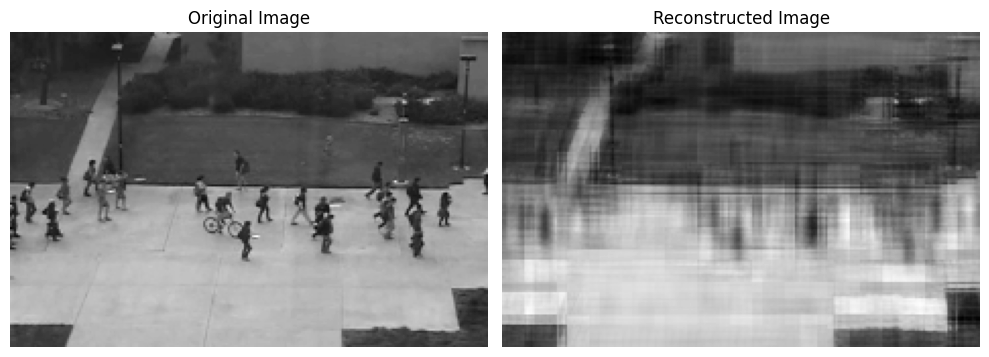

In [100]:
import matplotlib.pyplot as plt
import numpy as np

original_image = image_tensor.squeeze() 
reconstructed_image = output.squeeze()  

original_image = (original_image + 1) / 2.0
reconstructed_image = (reconstructed_image + 1) / 2.0

original_image = np.clip(original_image, 0, 1)
reconstructed_image = np.clip(reconstructed_image, 0, 1)

plt.figure(figsize=(10, 5))

print(original_image)

plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(original_image, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Reconstructed Image")
plt.imshow(reconstructed_image, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()


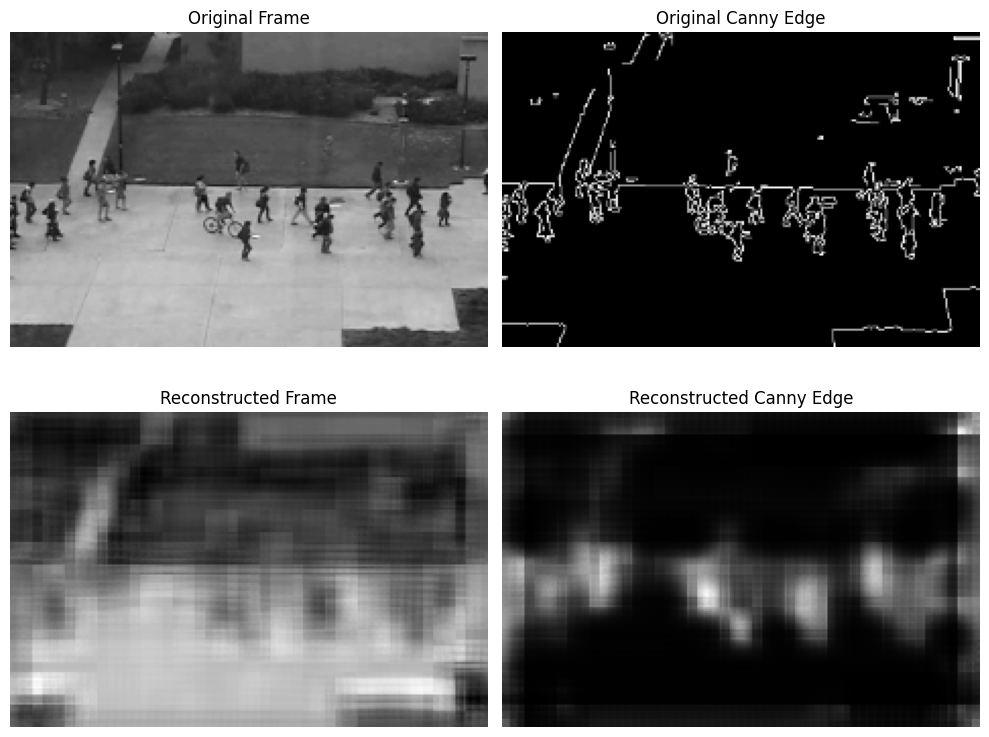

In [77]:
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt

model.eval()

image_path = "/kaggle/input/anomaly1/UCSDped2/Test/Test001/136.tif"
image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)

if len(image.shape) == 3:
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

edges = cv2.Canny(image, 100, 200)

target_size = (235, 155)
image = cv2.resize(image, target_size)
edges = cv2.resize(edges, target_size)

image = image.astype(np.float32) / 255.0
edges = edges.astype(np.float32) / 255.0

image = 2 * image - 1
edges = 2 * edges - 1

image_tensor = torch.tensor(image, dtype=torch.float32).unsqueeze(0)
edges_tensor = torch.tensor(edges, dtype=torch.float32).unsqueeze(0)

input_tensor = torch.cat((image_tensor, edges_tensor), dim=0)
input_tensor = input_tensor.unsqueeze(0)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_tensor = input_tensor.to(device)
model = model.to(device)

output = model(input_tensor)

input_tensor = input_tensor.detach().cpu().numpy().squeeze(0)
output = output.detach().cpu().numpy().squeeze(0)

original_frame = (input_tensor[0] + 1) / 2
original_edges = (input_tensor[1] + 1) / 2
reconstructed_frame = (output[0] + 1) / 2
reconstructed_edges = (output[1] + 1) / 2

fig, axes = plt.subplots(2, 2, figsize=(10, 8))

axes[0, 0].imshow(original_frame, cmap="gray")
axes[0, 0].set_title("Original Frame")
axes[0, 0].axis("off")

axes[0, 1].imshow(original_edges, cmap="gray")
axes[0, 1].set_title("Original Canny Edge")
axes[0, 1].axis("off")

axes[1, 0].imshow(reconstructed_frame, cmap="gray")
axes[1, 0].set_title("Reconstructed Frame")
axes[1, 0].axis("off")

axes[1, 1].imshow(reconstructed_edges, cmap="gray")
axes[1, 1].set_title("Reconstructed Canny Edge")
axes[1, 1].axis("off")

plt.tight_layout()
plt.show()


Frame Reconstruction Error: [3341.4583, 3472.1792]
0


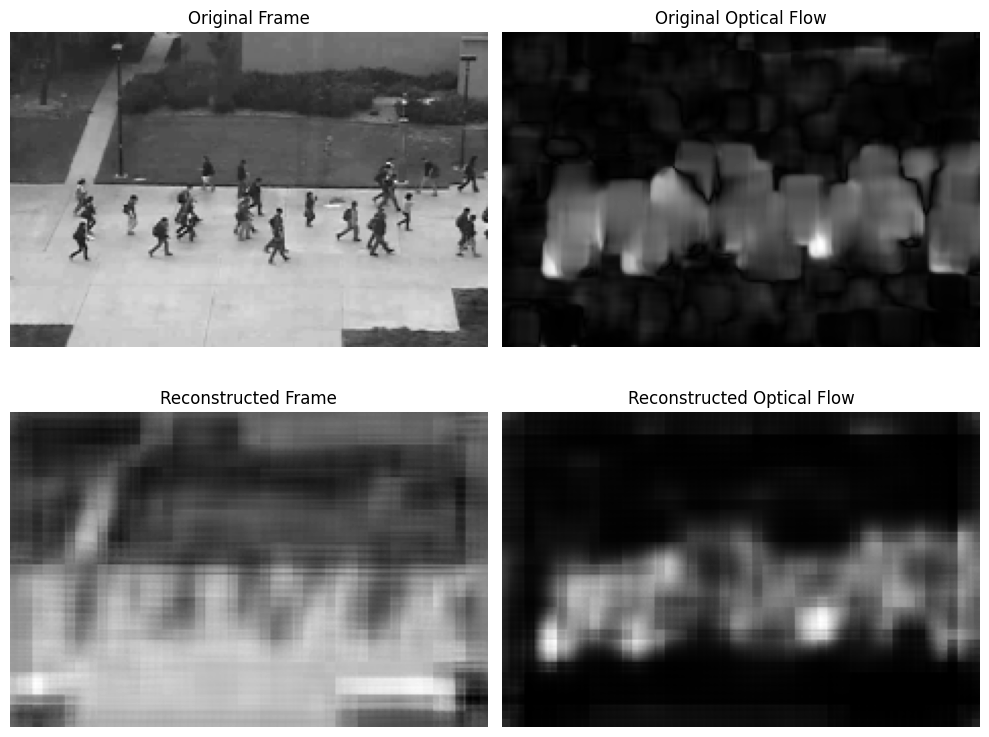

In [20]:
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt

model.eval()

frame1_path = "/kaggle/input/anomaly1/UCSDped2/Test/Test001/001.tif"
frame2_path = "/kaggle/input/anomaly1/UCSDped2/Test/Test001/002.tif"

frame1 = cv2.imread(frame1_path, cv2.IMREAD_GRAYSCALE)
frame2 = cv2.imread(frame2_path, cv2.IMREAD_GRAYSCALE)

target_size = (235, 155)
frame1 = cv2.resize(frame1, target_size)
frame2 = cv2.resize(frame2, target_size)

flow = cv2.calcOpticalFlowFarneback(frame1, frame2, None,
                                    pyr_scale=0.5, levels=3, winsize=15,
                                    iterations=3, poly_n=5, poly_sigma=1.2, flags=0)

flow_x = flow[..., 0]
flow_y = flow[..., 1]
magnitude = np.sqrt(flow_x ** 2 + flow_y ** 2)

frame1 = frame1.astype(np.float32) / 255.0
magnitude = magnitude.astype(np.float32)
magnitude = magnitude / np.max(magnitude)

frame1 = 2 * frame1 - 1
magnitude = 2 * magnitude - 1

frame_tensor = torch.tensor(frame1, dtype=torch.float32).unsqueeze(0)
flow_tensor = torch.tensor(magnitude, dtype=torch.float32).unsqueeze(0)
input_tensor = torch.cat((frame_tensor, flow_tensor), dim=0)

input_tensor = input_tensor.unsqueeze(0)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_tensor = input_tensor.to(device)
model = model.to(device)

output = model(input_tensor)

input_tensor = input_tensor.detach().cpu().numpy().squeeze(0)
output = output.detach().cpu().numpy().squeeze(0)

original_frame = (input_tensor[0] + 1) / 2
original_flow = (input_tensor[1] + 1) / 2
reconstructed_frame = (output[0] + 1) / 2
reconstructed_flow = (output[1] + 1) / 2

all_pixel_errors = compute_per_pixel_reconstruction_error(input_tensor, output)
fre_values = [compute_frame_reconstruction_error(pixel_errors) for pixel_errors in all_pixel_errors]

print(f"Frame Reconstruction Error: {fre_values}")
print(flattened_gt[179])

fig, axes = plt.subplots(2, 2, figsize=(10, 8))

axes[0, 0].imshow(original_frame, cmap="gray")
axes[0, 0].set_title("Original Frame")
axes[0, 0].axis("off")

axes[0, 1].imshow(original_flow, cmap="gray")
axes[0, 1].set_title("Original Optical Flow")
axes[0, 1].axis("off")

axes[1, 0].imshow(reconstructed_frame, cmap="gray")
axes[1, 0].set_title("Reconstructed Frame")
axes[1, 0].axis("off")

axes[1, 1].imshow(reconstructed_flow, cmap="gray")
axes[1, 1].set_title("Reconstructed Optical Flow")
axes[1, 1].axis("off")

plt.tight_layout()
plt.show()


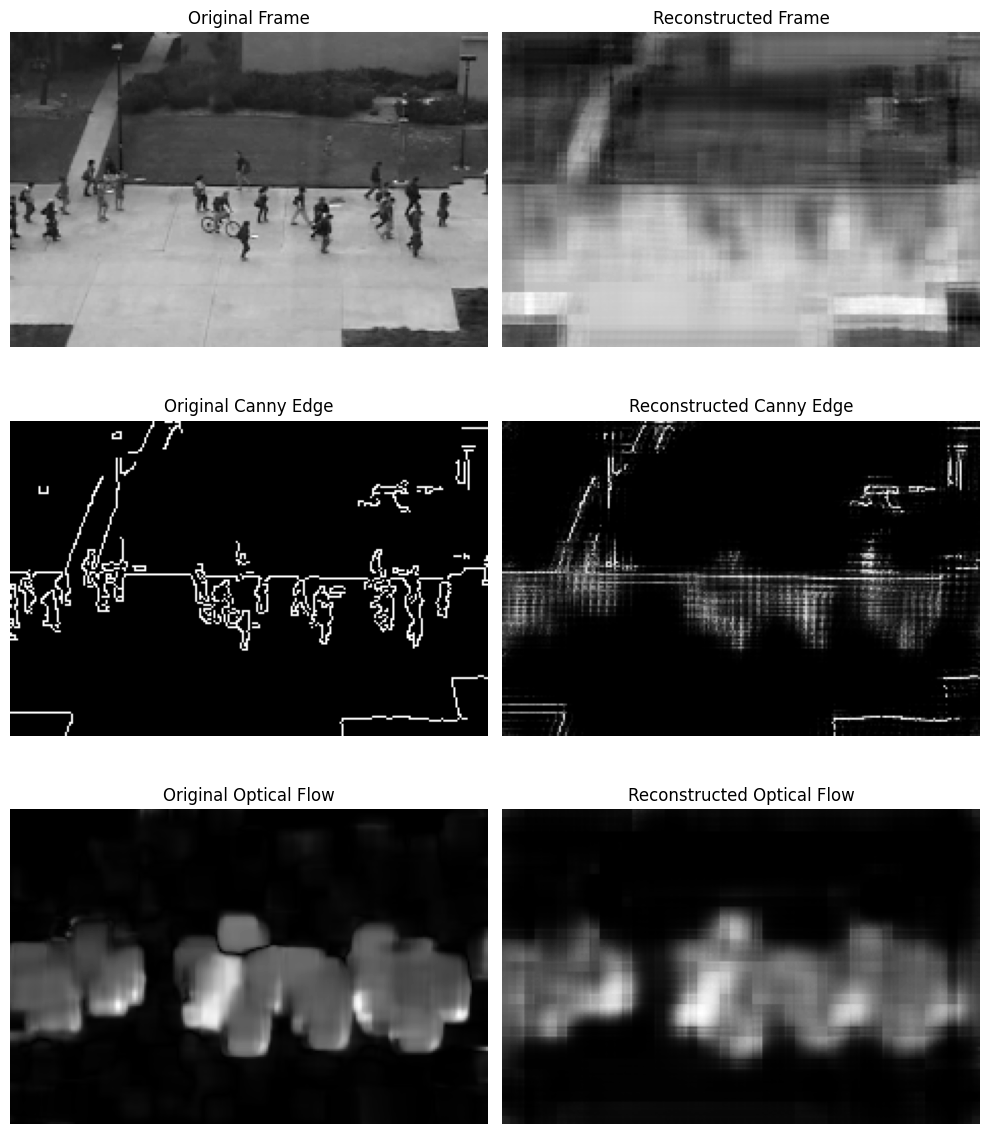

In [20]:
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt

model.eval()

frame1_path = "/kaggle/input/anomaly1/UCSDped2/Test/Test001/135.tif"
frame2_path = "/kaggle/input/anomaly1/UCSDped2/Test/Test001/136.tif"

frame1 = cv2.imread(frame1_path, cv2.IMREAD_GRAYSCALE)
frame2 = cv2.imread(frame2_path, cv2.IMREAD_GRAYSCALE)

target_size = (235, 155)
frame1 = cv2.resize(frame1, target_size)
frame2 = cv2.resize(frame2, target_size)

canny_edges = cv2.Canny(frame1, 100, 200)
canny_edges = cv2.resize(canny_edges, target_size)

flow = cv2.calcOpticalFlowFarneback(frame1, frame2, None,
                                    pyr_scale=0.5, levels=3, winsize=15,
                                    iterations=3, poly_n=5, poly_sigma=1.2, flags=0)

flow_x = flow[..., 0]
flow_y = flow[..., 1]
magnitude = np.sqrt(flow_x ** 2 + flow_y ** 2)

frame1 = frame1.astype(np.float32) / 255.0
canny_edges = canny_edges.astype(np.float32) / 255.0
magnitude = magnitude.astype(np.float32)
magnitude = magnitude / np.max(magnitude)

frame1 = 2 * frame1 - 1
canny_edges = 2 * canny_edges - 1
magnitude = 2 * magnitude - 1

frame_tensor = torch.tensor(frame1, dtype=torch.float32).unsqueeze(0)
canny_tensor = torch.tensor(canny_edges, dtype=torch.float32).unsqueeze(0)
flow_tensor = torch.tensor(magnitude, dtype=torch.float32).unsqueeze(0)

input_tensor = torch.cat((frame_tensor, canny_tensor, flow_tensor), dim=0)
input_tensor = input_tensor.unsqueeze(0)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_tensor = input_tensor.to(device)
model = model.to(device)

output = model(input_tensor)

input_tensor = input_tensor.detach().cpu().numpy().squeeze(0)
output = output.detach().cpu().numpy().squeeze(0)

original_frame = (input_tensor[0] + 1) / 2
original_canny = (input_tensor[1] + 1) / 2
original_flow = (input_tensor[2] + 1) / 2

reconstructed_frame = (output[0] + 1) / 2
reconstructed_canny = (output[1] + 1) / 2
reconstructed_flow = (output[2] + 1) / 2

all_pixel_errors = compute_per_pixel_reconstruction_error(input_tensor, output)
fre_values = [compute_frame_reconstruction_error(pixel_errors) for pixel_errors in all_pixel_errors]

fig, axes = plt.subplots(3, 2, figsize=(10, 12))

axes[0, 0].imshow(original_frame, cmap="gray")
axes[0, 0].set_title("Original Frame")
axes[0, 0].axis("off")

axes[0, 1].imshow(reconstructed_frame, cmap="gray")
axes[0, 1].set_title("Reconstructed Frame")
axes[0, 1].axis("off")

axes[1, 0].imshow(original_canny, cmap="gray")
axes[1, 0].set_title("Original Canny Edge")
axes[1, 0].axis("off")

axes[1, 1].imshow(reconstructed_canny, cmap="gray")
axes[1, 1].set_title("Reconstructed Canny Edge")
axes[1, 1].axis("off")

axes[2, 0].imshow(original_flow, cmap="gray")
axes[2, 0].set_title("Original Optical Flow")
axes[2, 0].axis("off")

axes[2, 1].imshow(reconstructed_flow, cmap="gray")
axes[2, 1].set_title("Reconstructed Optical Flow")
axes[2, 1].axis("off")

plt.tight_layout()
plt.show()
